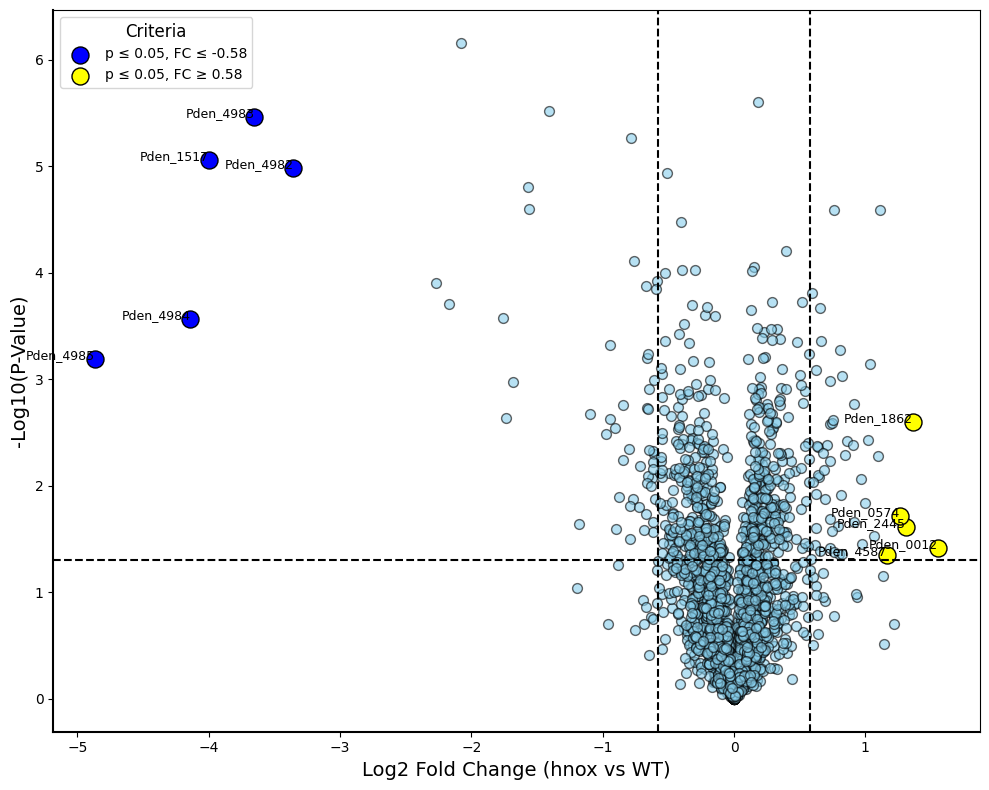

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Phyton-Biology/refs/heads/main/Exercise%202%20Data.csv'
df = pd.read_csv(url)
df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['WT_1', 'WT_2', 'WT_3']].mean(axis=1)
df['hnox_Mean'] = df[['hnox_1', 'hnox_2', 'hnox_3']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_1', 'WT_2', 'WT_3']].values,
    df[['hnox_1', 'hnox_2', 'hnox_3']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
significance_threshold = 0.05
fold_change_cutoff = 0.58

# Filter for statistically significant genes
significant_genes_df = df[(df['P_Value'] <= significance_threshold) & (abs(df['Log2_FC']) >= fold_change_cutoff)]

# Get top 5 down-regulated genes
down_regulated_top5 = significant_genes_df[significant_genes_df['Log2_FC'] < -fold_change_cutoff].sort_values(by='Log2_FC', ascending=True).head(5)

# Get top 5 up-regulated genes
up_regulated_top5 = significant_genes_df[significant_genes_df['Log2_FC'] >= fold_change_cutoff].sort_values(by='Log2_FC', ascending=False).head(5)

# Concatenate for labeling
top_genes = pd.concat([down_regulated_top5, up_regulated_top5])

# Separate significant genes for coloring (using the refined top 5 from each side)
left_candidates = down_regulated_top5
right_candidates = up_regulated_top5


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='blue', s=150, edgecolor='black', marker='o', label=f'p ≤ {significance_threshold}, FC ≤ -{fold_change_cutoff}')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='yellow', s=150, edgecolor='black', marker='o', label=f'p ≤ {significance_threshold}, FC ≥ {fold_change_cutoff}')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(significance_threshold), color='black', linestyle='--')
plt.axvline(fold_change_cutoff, color='black', linestyle='--')
plt.axvline(-fold_change_cutoff, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()
#The volcano plot shows the top 5 up and down regulated gene, first p-value and log2 fold change was used to identify significant genes.
#Then Log2 fold change was used to select the top 5 up (>0.58) and down (<-0.58) regulated genes.

In [11]:
print("\nTop 5 Upregulated Genes:")
display(top_genes[top_genes['Log2_FC'] > 0].nlargest(5, 'Log2_FC')[['Gene', 'Log2_FC']])

print("\nTop 5 Downregulated Genes:")
display(top_genes[top_genes['Log2_FC'] < 0].nsmallest(5, 'Log2_FC')[['Gene', 'Log2_FC']])


Top 5 Upregulated Genes:


,Gene,Log2_FC
11,Pden_0012,1.552483
916,Pden_1862,1.360097
1311,Pden_2445,1.307066
264,Pden_0574,1.260706
2440,Pden_4587,1.161750



Top 5 Downregulated Genes:


,Gene,Log2_FC
2618,Pden_4985,-4.864214
2617,Pden_4984,-4.140856
743,Pden_1517,-3.999678
2616,Pden_4983,-3.652178
2615,Pden_4982,-3.355166
